In [1]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('../../data/cve_2018-2020_X_train.csv')
y_train = pd.read_csv('../../data/cve_2018-2020_y_train.csv')

X_test = pd.read_csv('../../data/cve_2018-2020_X_test.csv')
y_test = pd.read_csv('../../data/cve_2018-2020_y_test.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train['cvssV3_scope'].value_counts(dropna=False) / y_train.shape[0])
print(y_test['cvssV3_scope'].value_counts(dropna=False) / y_test.shape[0])
print(X_train.info())
print(y_train.info())

(22963, 2)
(22963, 2)
(22963, 16)
(22963, 16)
UNCHANGED    0.830379
CHANGED      0.169621
Name: cvssV3_scope, dtype: float64
UNCHANGED    0.826852
CHANGED      0.173148
Name: cvssV3_scope, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CVE_ID       22963 non-null  object
 1   Description  22963 non-null  object
dtypes: object(2)
memory usage: 358.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cvssV3_vectorString           22963 non-null  object 
 1   cvssV3_attackVector           22963 non-null  object 
 2   cvssV3_attackComplexity       22963 non-null  object 
 3   cvssV3_privilegesRequired     22963 non-null  object 
 4   cvssV3_us

**Training Hugging Face Bert-Small model to classify CVE vulnerability descriptions according to whether or not a "scope" change occurs**

**Scope**: The Scope metric captures whether a vulnerability in one vulnerable component impacts resources in components beyond its security scope.

Formally, a security authority is a mechanism (e.g., an application, an operating system, firmware, a sandbox environment) that defines and enforces access control in terms of how certain subjects/actors (e.g., human users, processes) can access certain restricted objects/resources (e.g., files, CPU, memory) in a controlled manner. All the subjects and objects under the jurisdiction of a single security authority are considered to be under one security scope. If a vulnerability in a vulnerable component can affect a component which is in a different security scope than the vulnerable component, a Scope change occurs. Intuitively, whenever the impact of a vulnerability breaches a security/trust boundary and impacts components outside the security scope in which vulnerable component resides, a Scope change occurs.

The security scope of a component encompasses other components that provide functionality solely to that component, even if these other components have their own security authority. For example, a database used solely by one application is considered part of that application’s security scope even if the database has its own security authority, e.g., a mechanism controlling access to database records based on database users and associated database privileges.

In [2]:
label_column_name = "cvssV3_scope"
train_labels = y_train.loc[:, label_column_name]
test_labels = y_test.loc[:, label_column_name]


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
print(le.classes_)

NUM_CLASSES = len(le.classes_)
print(NUM_CLASSES)

encoded_train_labels = le.transform(train_labels)
encoded_test_labels = le.transform(test_labels)

print(train_labels[:10], encoded_train_labels[:10])
print(len(X_train), len(train_labels), len(X_test), len(test_labels))

['CHANGED' 'UNCHANGED']
2
0    UNCHANGED
1    UNCHANGED
2    UNCHANGED
3      CHANGED
4    UNCHANGED
5    UNCHANGED
6    UNCHANGED
7    UNCHANGED
8    UNCHANGED
9    UNCHANGED
Name: cvssV3_scope, dtype: object [1 1 1 0 1 1 1 1 1 1]
22963 22963 22963 22963


In [3]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('prajjwal1/bert-small')

In [4]:
train_encodings = tokenizer(X_train.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)

In [5]:
import torch

class CVEDataset(torch.utils.data.Dataset):
    def __init__(self, X, encodings, labels, encoded_labels):
        self.cve_id = X.loc[:,"CVE_ID"].tolist()
        self.texts = X.loc[:,"Description"].tolist()
        self.encodings = encodings
        self.labels = labels.tolist()
        self.encoded_labels = encoded_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['text_labels'] = self.labels[idx]
        item['encoded_labels'] = torch.tensor(self.encoded_labels[idx])
        item['CVE_ID'] = self.cve_id[idx]
        item['vulnerability_description'] = self.texts[idx]
        
        return item

    def __len__(self):
        return len(self.labels)


In [6]:
train_dataset = CVEDataset(X_train, train_encodings, train_labels, encoded_train_labels)
test_dataset = CVEDataset(X_test, test_encodings, test_labels, encoded_test_labels)

In [7]:
train_dataset[0]

{'input_ids': tensor([  101,  1037, 18130,  1999, 26408, 16380, 17083,  8080,  1006, 17083,
          8202,  1007,  4007,  2005, 26408, 16771, 23944,  2692,  2186, 15924,
          2071,  3499,  2019, 14477, 14317,  4765, 17872,  1010,  2334, 17346,
          2000, 11826, 26408,  5851,  9573, 27354, 14148,  1998,  7170,  1037,
         20419,  4007,  3746,  2006,  2019,  5360,  5080,  1012,  1996, 18130,
          2003,  2349,  2000,  1996,  3739,  1997,  1037,  5023,  3094,  1999,
          1996,  5360,  4007,  1012,  2019, 17346,  2071, 18077,  2023, 18130,
          2011,  7176,  2000,  2019,  5360,  5080,  3081,  1996, 10122,  1010,
          6932,  1996,  5080,  2046, 17083,  8202,  5549,  1010,  1998,  3015,
          1037, 24391,  5418,  2000,  1037,  3563,  3638,  4769,  2006,  1996,
          5080,  1012,  1037,  3144, 18077,  2071,  3499,  1996, 17346,  2000,
         11826,  8085, 27354, 14148,  2011, 26408,  5851,  9573,  2974,  1998,
          7170,  1037, 20419,  4007,  3

In [8]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-small', num_labels=NUM_CLASSES)
model

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [9]:
for param in model.base_model.parameters():
    param.requires_grad = False
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

classifier.weight tensor([[ 0.0246,  0.0130,  0.0242,  ..., -0.0276, -0.0044, -0.0277],
        [ 0.0260,  0.0299, -0.0263,  ...,  0.0074,  0.0120,  0.0479]])
classifier.bias tensor([0., 0.])


In [10]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

training_loss_batch = []
training_loss_epoch = []

for epoch in range(3):
    model.train()
    training_loss = 0
    num_correct = 0 
    num_examples = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['encoded_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        training_loss_batch.append(loss.data.item())
        training_loss += loss.data.item() * input_ids.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    training_loss /= len(train_loader.dataset)
    training_loss_epoch.append(training_loss)
    
    print('Epoch: {}, Training Loss: {}, Training Accuracy = {}'.format(epoch, training_loss, num_correct / num_examples))

  

Epoch: 0, Training Loss: 0.45092059301345216, Training Accuracy = 0.826503505639507
Epoch: 1, Training Loss: 0.42653330749259544, Training Accuracy = 0.8303793058398293
Epoch: 2, Training Loss: 0.4136844583588008, Training Accuracy = 0.8307276923746897


In [11]:
for param in model.base_model.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

bert.embeddings.word_embeddings.weight tensor([[ 0.0770, -0.1024,  0.0109,  ...,  0.0265,  0.0527, -0.0099],
        [-0.0062, -0.0448,  0.0068,  ...,  0.0460,  0.0177, -0.0487],
        [-0.0014, -0.0184,  0.0207,  ...,  0.0936,  0.0561, -0.0690],
        ...,
        [-0.0539, -0.0298,  0.0711,  ...,  0.0057,  0.0172, -0.0437],
        [ 0.0446, -0.0571,  0.0028,  ..., -0.0138,  0.0534, -0.0741],
        [ 0.0798,  0.0307, -0.0254,  ...,  0.0389,  0.0417, -0.0208]])
bert.embeddings.position_embeddings.weight tensor([[-2.2368e-03, -1.6215e-02, -5.7656e-03,  ..., -8.1258e-02,
         -1.8137e-02,  1.0507e-03],
        [-1.4434e-02, -9.5276e-03, -3.3733e-04,  ...,  2.2632e-02,
         -2.4823e-02, -2.0542e-02],
        [-1.3487e-02, -6.8095e-05,  7.1685e-03,  ...,  4.7153e-03,
         -1.9992e-03,  6.1711e-03],
        ...,
        [ 2.4908e-02, -1.1784e-03, -9.2854e-03,  ...,  1.1964e-03,
         -1.9798e-02,  4.2636e-03],
        [ 2.8236e-02, -1.1161e-02,  1.2986e-02,  ..., -1.31

In [12]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

training_loss_batch = []
training_loss_epoch = []

for epoch in range(3):
    model.train()
    training_loss = 0
    num_correct = 0 
    num_examples = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['encoded_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        training_loss_batch.append(loss.data.item())
        training_loss += loss.data.item() * input_ids.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    training_loss /= len(train_loader.dataset)
    training_loss_epoch.append(training_loss)
    
    print('Epoch: {}, Training Loss: {}, Training Accuracy = {}'.format(epoch, training_loss, num_correct / num_examples))

  

Epoch: 0, Training Loss: 0.15178899181620528, Training Accuracy = 0.9565823280930192
Epoch: 1, Training Loss: 0.10631314437291801, Training Accuracy = 0.9675129556242651
Epoch: 2, Training Loss: 0.0767595440908382, Training Accuracy = 0.9746984279057614


In [13]:
#model.save_pretrained('./bert-small-vulnerability_scope-classification')

In [14]:
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['encoded_labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    test_loss += loss.data.item() * input_ids.size(0)
    correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

        
print('Test Loss: {}, Test Accuracy = {}'.format(test_loss, num_correct / num_examples))

Test Loss: 0.1395465577828686, Test Accuracy = 0.9544920088838567


**Save the predictions obtained on the test set for further analysis**

In [15]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('./bert-small-vulnerability_scope-classification')
model.eval()

test_loader = DataLoader(test_dataset, batch_size=16)


num_correct = 0 
num_examples = 0
test_loss = 0
predicted_labels_list = []
predicted_labels_score_list = []
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['encoded_labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    test_loss += loss.data.item() * input_ids.size(0)
    predicted_labels = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1]
    predicted_labels_list.extend(predicted_labels.tolist())
    predicted_labels_score = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[0]
    predicted_labels_score_list.extend(predicted_labels_score.tolist())
    correct = torch.eq(predicted_labels, labels)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

        
print('Test Loss: {}, Test Accuracy = {}'.format(test_loss, num_correct / num_examples))
print('predicted labels:', predicted_labels_list, 'scores:', predicted_labels_score_list)

Test Loss: 0.1395465577828686, Test Accuracy = 0.9544920088838567
predicted labels: [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = test_dataset[:]['encoded_labels'].numpy()
y_pred = np.array(predicted_labels_list)

print("accuracy: ", accuracy_score(y_true, y_pred))
print("precision: ", precision_score(y_true, y_pred, average='weighted'))
print("recall: ", recall_score(y_true, y_pred, average='weighted'))
print("f1 score: ", f1_score(y_true, y_pred, average='weighted'))


print("confusion matrix: ")
print(confusion_matrix(y_true, y_pred))

accuracy:  0.9544920088838567
precision:  0.9553008231865774
recall:  0.9544920088838567
f1 score:  0.9548294930663336
confusion matrix: 
[[ 3530   446]
 [  599 18388]]


In [17]:
class_label = list(le.classes_)
class_label
predicted_labels_char = [class_label[i] for i in predicted_labels_list]

print(len(predicted_labels_char))
print(len(predicted_labels_list))


22963
22963


(array([  183.,   193.,   204.,   211.,   255.,   292.,   375.,   559.,
          955., 19736.]),
 array([0.50024378, 0.55017505, 0.60010632, 0.65003759, 0.69996886,
        0.74990013, 0.7998314 , 0.84976267, 0.89969394, 0.94962521,
        0.99955648]),
 <BarContainer object of 10 artists>)

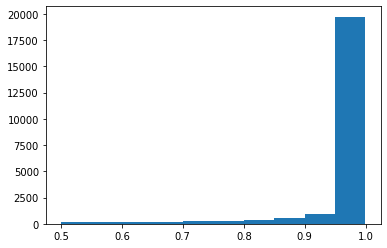

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(predicted_labels_score_list, bins=10)


In [19]:
from scipy import stats

print("percentile of 0.9: ", stats.percentileofscore(predicted_labels_score_list, 0.95))

percentile of 0.9:  14.109654661847319


In [20]:
file_name = 'scope'

import pickle

with open(file_name + "_predicted_class_int.txt", "wb") as f1:
    pickle.dump(predicted_labels_list, f1)
    
with open(file_name + "_predicted_labels_char.txt", "wb") as f2:
    pickle.dump(predicted_labels_char, f2)
    
with open(file_name + "_predicted_class_confidence_score.txt", "wb") as f3:
    pickle.dump(predicted_labels_score_list, f3)
 

In [21]:
with open(file_name + "_predicted_class_int.txt", "rb") as f1:
    pred_class = pickle.load(f1)
    
with open(file_name + "_predicted_labels_char.txt", "rb") as f2:
    pred_label = pickle.load(f2)
    
with open(file_name + "_predicted_class_confidence_score.txt", "rb") as f3:
    pred_confidence_score = pickle.load(f3)
    
print(len(pred_class), len(pred_label), len(pred_confidence_score))
print(pred_class, pred_label, pred_confidence_score)

22963 22963 22963
[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

**Explaining classification results using gradient-based saliency**

In [22]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

test_batch = next(iter(test_loader))
test_batch['input_ids']
input_ids = test_batch['input_ids']
attention_mask = test_batch['attention_mask']
labels = test_batch['encoded_labels']



outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

print(outputs.loss)
print(outputs.logits)
print(torch.max(F.softmax(outputs.logits, dim=1), dim=1))
print(labels)

tensor(0.0084, grad_fn=<NllLossBackward>)
tensor([[-2.9714,  2.7461],
        [-1.7858,  1.4738],
        [-3.3312,  3.2062],
        [ 3.3142, -3.3586],
        [-1.9610,  2.0402],
        [-3.0926,  3.1207],
        [-3.1188,  2.8009],
        [ 3.2922, -3.3737],
        [-1.1144,  1.7233],
        [-3.8291,  3.7733],
        [-3.1460,  2.7373],
        [-2.9136,  3.0272],
        [ 3.3919, -3.3704],
        [-3.6663,  3.5047],
        [-3.7671,  3.6659],
        [ 3.1982, -3.1277]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([0.9967, 0.9630, 0.9986, 0.9987, 0.9820, 0.9980, 0.9973, 0.9987, 0.9447,
        0.9995, 0.9972, 0.9974, 0.9988, 0.9992, 0.9994, 0.9982],
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]))
tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0])


In [23]:
selected_idx = -1
input_ids[selected_idx].tolist()

[101,
 2892,
 1011,
 2609,
 5896,
 2075,
 1006,
 1060,
 4757,
 1007,
 18130,
 1999,
 1996,
 4773,
 21318,
 1999,
 5653,
 2386,
 2077,
 1016,
 1012,
 1015,
 1012,
 2656,
 4473,
 6556,
 17857,
 2000,
 1999,
 20614,
 15275,
 4773,
 5896,
 2030,
 16129,
 3081,
 1037,
 5310,
 1011,
 7047,
 24471,
 2140,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [24]:
#transform each input token into an one-hot encoded representation.

from torch.autograd import Variable

input_embedding = model.get_input_embeddings()
vocab_size = input_embedding.weight.shape[0]

input_ids_one_hot = torch.nn.functional.one_hot(input_ids[selected_idx], num_classes=vocab_size)
input_ids_one_hot = input_ids_one_hot.type(torch.float)
input_ids_one_hot = Variable(input_ids_one_hot, requires_grad=True) #to allow the computation of the gradients with respect to the input 
print(input_ids_one_hot.grad)

None


In [25]:
#Calculate the input embeddings manually and pass them to the model through the inputs_embeds argument
inputs_embeds = torch.matmul(input_ids_one_hot, input_embedding.weight)
embedding_dim = input_embedding.weight.shape[1]
inputs_embeds = torch.mul(inputs_embeds, torch.cat([attention_mask[selected_idx].unsqueeze(1)]*embedding_dim, dim=1))


outputs = model(inputs_embeds=inputs_embeds.unsqueeze(0), attention_mask=attention_mask[selected_idx].unsqueeze(0), labels=labels[selected_idx].unsqueeze(0))

print("loss:", outputs.loss)
print("logits:", outputs.logits)

predicted_label = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1].item()
print("predicted label (after softmax):", predicted_label)
print("score for predicted label (after softmax):", torch.max(F.softmax(outputs.logits, dim=1), dim=1)[0].item())
print("sample true label:", labels[selected_idx])

outputs.logits[0][predicted_label].backward() #compute the gradient of the logit (predicted, the one with the highest score)
print(input_ids_one_hot.grad)                  #with respect to the input

loss: tensor(0.0018, grad_fn=<NllLossBackward>)
logits: tensor([[ 3.1982, -3.1277]], grad_fn=<AddmmBackward>)
predicted label (after softmax): 0
score for predicted label (after softmax): 0.9982138872146606
sample true label: tensor(0)
tensor([[ 0.0014,  0.0024,  0.0154,  ...,  0.0098,  0.0099,  0.0107],
        [ 0.0105,  0.0173,  0.0101,  ...,  0.0122,  0.0249,  0.0466],
        [ 0.0038, -0.0056, -0.0040,  ..., -0.0052, -0.0050,  0.0046],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [26]:
connectivity_tensor = torch.linalg.norm(input_ids_one_hot.grad, dim=1)
connectivity_tensor = connectivity_tensor/torch.max(connectivity_tensor)
connectivity_tensor

tensor([0.1121, 0.2753, 0.0873, 0.4970, 0.4645, 0.2971, 0.4454, 0.4048, 1.0000,
        0.2200, 0.1740, 0.0999, 0.0444, 0.1452, 0.0957, 0.0306, 0.0559, 0.3788,
        0.0409, 0.0389, 0.0410, 0.0578, 0.0498, 0.0570, 0.1283, 0.3180, 0.1997,
        0.0557, 0.0539, 0.1324, 0.0681, 0.0938, 0.1696, 0.0466, 0.1722, 0.0631,
        0.0341, 0.0825, 0.0232, 0.0509, 0.0659, 0.0418, 0.0490, 0.1580, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [27]:
indices_sorted_by_connectivity = torch.argsort(connectivity_tensor)
input_tokens = tokenizer.convert_ids_to_tokens(list(input_ids[selected_idx]))
top_3_indices_sorted = indices_sorted_by_connectivity[-3:].flip(dims=(0,))

print(input_tokens)
print("Most influential words by order:")
for position, score in zip(top_3_indices_sorted,
                                 connectivity_tensor[top_3_indices_sorted]):
    print(input_tokens[position.item()], "\tposition: ", position.item(), "\tconnectivity weight: ", score.item())

['[CLS]', 'cross', '-', 'site', 'script', '##ing', '(', 'x', '##ss', ')', 'vulnerability', 'in', 'the', 'web', 'ui', 'in', 'mail', '##man', 'before', '2', '.', '1', '.', '26', 'allows', 'remote', 'attackers', 'to', 'in', '##ject', 'arbitrary', 'web', 'script', 'or', 'html', 'via', 'a', 'user', '-', 'options', 'ur', '##l', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [28]:
import re

def print_texts_with_top_influential_words_in_bold(input_text_str, input_tokens, connectivity_tensor, top_k=3):
    #input_text_str: python string coreesponding to the raw textual input
    #input_tokens: python list corresponding to the tokenized representation of the input
    #connectivity_tensor: pytorch tensor containing the gradient norm of the gradient of the logit with respect to each input token
    #top_k: int representing the maximum number of top words to consider
    BOLD = '\033[1m'
    END = '\033[0m'
    
    output_str = input_text_str
    indices_sorted_by_connectivity = torch.argsort(connectivity_tensor)
    top_indices_sorted = indices_sorted_by_connectivity[-top_k:].flip(dims=(0,))
    
    print("Most influential words by order:")
    for position, score in zip(top_indices_sorted,
                                     connectivity_tensor[top_indices_sorted]):
        print(input_tokens[position.item()], "\tposition: ", position.item(), "\tconnectivity weight: ", score.item())
        
        if input_tokens[position.item()] in ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']:
            continue
        
        #find the indices of every tokens containing the selected word (or token)
        indices_all_matches = [i for i, x in enumerate(input_tokens) if re.sub('^##', '', input_tokens[position.item()]) in x]
        #keep only the position intended by the model (when multiple occurences of the same word).
        #For example, if selected words occurs 3 times in the description, and the algorithms is mostly influenced by
        #second occurrence, then return 1, 3rd occurence return 2, etc
        position_of_the_intended_match = [i for i, x in enumerate(indices_all_matches) if x == position.item()]
        
        test_sub = re.escape(re.sub('^##', '', input_tokens[position.item()]))
        res = [i.start() for i in re.finditer(test_sub, output_str, re.IGNORECASE)]
        idx = position_of_the_intended_match[0]
        output_str = output_str[:res[idx]] + BOLD + output_str[res[idx]:res[idx]+len(test_sub)] + END + output_str[res[idx]+len(test_sub):]
    print(output_str)
    return output_str

In [29]:
input_text_str = test_batch['vulnerability_description'][selected_idx]
print_texts_with_top_influential_words_in_bold(input_text_str, input_tokens, connectivity_tensor, top_k=5)

Most influential words by order:
##ss 	position:  8 	connectivity weight:  1.0
site 	position:  3 	connectivity weight:  0.4969918429851532
script 	position:  4 	connectivity weight:  0.46446534991264343
( 	position:  6 	connectivity weight:  0.4454331696033478
x 	position:  7 	connectivity weight:  0.404765784740448
Cross-site scripting (XSS) vulnerability in the web UI in Mailman before 2.1.26 allows remote attackers to inject arbitrary web script or HTML via a user-options URL.


'Cross-\x1bsite\x1b \x1bscript\x1bing \x1b(\x1bX\x1b\x1b\x1bSS\x1b) vulnerability in the web UI in Mailman before 2.1.26 allows remote attackers to inject arbitrary web script or HTML via a user-options URL.'